In [1]:
# EDA
import pandas as pd
import numpy as np

# oracle sql
import cx_Oracle

## date handling
from datetime import datetime, timedelta
import pytz
from pytz import timezone

# visualizing
import seaborn as sns
import matplotlib.pyplot as plt

# modelling
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor

# accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# scaling
from sklearn.preprocessing import StandardScaler

# deployment
import pickle as pkl
from sklearn.pipeline import Pipeline

## for ignoring deprecation warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df=pd.read_parquet('df.parquet')
df=df.sort_values(['BANK_TIME'],ascending=True)

In [3]:
df.tail()

,BANK_TIME,TERMOWNER,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,DIRECTION,PIN,MARSTAT,BIRTH_DATE,HIREDATE,MCC,MCC_DESCRIPTION,MCC_GROUP,ID,CURRENCY,NAME
276923,2023-05-31 02:52:35,www.birbank.az,0.0,0.0,0.0,CREDIT,70JJ5LN,Subay,27.12.1999,08.12.2021,6012,Member Financial Institution-Merchandise,SERVICE PROVIDER,944,AZN,Азербайджанский манат
1768689,2023-05-31 02:56:15,www.birbank.az/mobil,1.0,0.0,1.8,CREDIT,5G4GHC0,Evli,23.07.1992,17.02.2015,4814,Telecommunication Serv.Includ. Local/L.D,UTILITY AND CABLE SERVICES,944,AZN,Азербайджанский манат
1835227,2023-05-31 03:33:51,www.birbank.az/creditpay,0.0,0.0,34.6,CREDIT,55FXY6L,Evli,11.12.1991,23.11.2015,6012,Member Financial Institution-Merchandise,SERVICE PROVIDER,944,AZN,Азербайджанский манат
1794771,2023-05-31 03:44:52,www.birbank.az/mobil,1.0,0.0,0.0,CREDIT,62CXFQA,Subay,19.11.1995,24.09.2019,4814,Telecommunication Serv.Includ. Local/L.D,UTILITY AND CABLE SERVICES,944,AZN,Азербайджанский манат
1032061,2023-05-31 03:52:51,www.birbank.az/mobil,1.0,0.1,21.5,CREDIT,8KZ2BVD,Subay,03.04.1999,07.07.2021,4814,Telecommunication Serv.Includ. Local/L.D,UTILITY AND CABLE SERVICES,944,AZN,Азербайджанский манат


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2067841 entries, 76696 to 1032061
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   BANK_TIME        datetime64[ns]
 1   TERMOWNER        object        
 2   CASHBACK_RATE    float64       
 3   CASHBACK_AMOUNT  float64       
 4   BALANCE_AFTER    float64       
 5   DIRECTION        object        
 6   PIN              object        
 7   MARSTAT          object        
 8   BIRTH_DATE       object        
 9   HIREDATE         object        
 10  MCC              object        
 11  MCC_DESCRIPTION  object        
 12  MCC_GROUP        object        
 13  ID               int64         
 14  CURRENCY         object        
 15  NAME             object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(11)
memory usage: 268.2+ MB


In [5]:
df.describe()

,BANK_TIME,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,ID
count,2067841,2.067841e+06,2.067841e+06,2.067841e+06,2.067841e+06
mean,2022-12-02 16:58:53.883129088,1.415615e+00,3.178639e-01,1.583896e+01,9.202852e+02
min,2021-09-10 00:06:00,0.000000e+00,0.000000e+00,-9.939000e+02,8.400000e+02
25%,2022-09-18 19:23:01,5.000000e-01,0.000000e+00,1.100000e+00,9.440000e+02
50%,2023-01-14 18:08:44,1.500000e+00,1.000000e-01,3.600000e+00,9.440000e+02
75%,2023-03-30 14:00:07,1.500000e+00,2.000000e-01,1.200000e+01,9.440000e+02
max,2023-05-31 03:52:51,4.000000e+01,5.000000e+02,2.017500e+03,9.780000e+02
std,NaN,1.302489e+00,2.422149e+00,5.019633e+01,4.365295e+01


In [6]:
df.shape

(2067841, 16)

In [7]:
print(df.duplicated().sum())

610


In [8]:
print(df.isna().sum())

BANK_TIME              0
TERMOWNER            184
CASHBACK_RATE          0
CASHBACK_AMOUNT        0
BALANCE_AFTER          0
DIRECTION              0
PIN                    0
MARSTAT            10459
BIRTH_DATE          8599
HIREDATE               0
MCC                    0
MCC_DESCRIPTION        0
MCC_GROUP              0
ID                     0
CURRENCY               0
NAME                   0
dtype: int64


In [9]:
pins_with_missing_birth_date = df.loc[df['BIRTH_DATE'].isna(), 'PIN'].unique()
print(pins_with_missing_birth_date)

['2HMSQWC' '2G6YY4S' '64VD1S7' '79M3S2S' '2S01CBB' '7B0NXNB' '7BG1FM4'
 '1ACPJ8A' '5UF6ZCH' '6ASJEYW' '6FGY79G' '695RS9Z' '2NNJ13X' '35TAZN2'
 '69V61VM' '2VJQK1L' '62SZ34W' '69RDZ6Q' '66C5MCC' '53J096K' '6E3LSS1'
 '2EX05D2' '60CFME6' '61ACKXS' '41SL261' '63BH03P' '2S90MKA' '6AWFSBZ'
 '5EKJR6D' '67C0RMU' '136GML5' '33Q2NRJ' '1ALBH5B']


In [10]:
columns_to_fill = ['MARSTAT', 'TERMOWNER', 'BIRTH_DATE']

for column in columns_to_fill:
    mode_value = df[column].mode().iloc[0]
    df[column].fillna(mode_value, inplace=True)

In [11]:
print(df.isna().sum())

BANK_TIME          0
TERMOWNER          0
CASHBACK_RATE      0
CASHBACK_AMOUNT    0
BALANCE_AFTER      0
DIRECTION          0
PIN                0
MARSTAT            0
BIRTH_DATE         0
HIREDATE           0
MCC                0
MCC_DESCRIPTION    0
MCC_GROUP          0
ID                 0
CURRENCY           0
NAME               0
dtype: int64


In [12]:
pd.DataFrame(df['MCC_GROUP'].value_counts())

,count
MCC_GROUP,
RETAIL STORES,653076
SERVICE PROVIDER,424212
VARIOUS SHOPS,322557
UTILITY AND CABLE SERVICES,268481
TRANSPORT,207732
AUTOMOBILES AND VEHICLES,76062
CLOTHING STORES,44591
BUSINESS SERVICES,15986
ENTERTAINMENT,13816


In [13]:
pd.DataFrame(df['MCC_DESCRIPTION'].value_counts()).head()

,count
MCC_DESCRIPTION,
"Grocery Stores, Supermarkets",601868
Member Financial Institution-Merchandise,420436
Telecommunication Serv.Includ. Local/L.D,190557
Taxicabs/Limousines,167413
"Eating Places, Restaurants",130708


In [14]:
pd.DataFrame(df.groupby(['MCC_GROUP'])['CASHBACK_AMOUNT'].sum()).sort_values(['CASHBACK_AMOUNT'],ascending=False).head()

,CASHBACK_AMOUNT
MCC_GROUP,
VARIOUS SHOPS,208597.1
RETAIL STORES,197262.9
CLOTHING STORES,60069.8
AUTOMOBILES AND VEHICLES,48135.0
PROFESSIONAL SERVICES,30228.7


## HIREDATE

In [15]:
# Convert 'HIREDATE' column to datetime with the correct format
df['HIREDATE'] = pd.to_datetime(df['HIREDATE'], format='%d.%m.%Y')

# Assuming all datetime objects in the 'HIREDATE' column are in a specific timezone
desired_timezone = pytz.timezone('UTC')

# Localize 'HIREDATE' column to the desired timezone
df['HIREDATE'] = df['HIREDATE'].dt.tz_localize(desired_timezone)

# Define your current datetime
current_datetime = pd.Timestamp('2023-06-01 18:43:00', tz=desired_timezone)

# Perform operations with the timezone-aware 'current_datetime' and 'df['HIREDATE']'
df['HIREDATE_Time_diff'] = (current_datetime - df['HIREDATE']).dt.days
df['HIREDATE_Hours'] = df['HIREDATE'].dt.hour
df['HIREDATE_Weekday'] = df['HIREDATE'].dt.weekday + 1
df['HIREDATE_Year'] = df['HIREDATE'].dt.year
df['HIREDATE_Day_of_Year'] = df['HIREDATE'].dt.day_of_year
df['HIREDATE_Month'] = df['HIREDATE'].dt.month

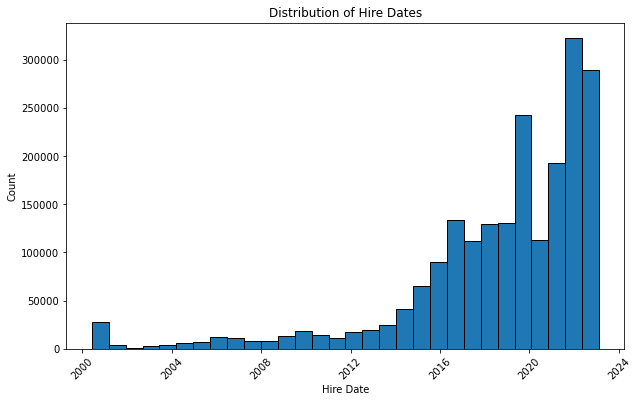

Min Hire Date: 2000-06-02 00:00:00+00:00
Max Hire Date: 2023-02-15 00:00:00+00:00
Mean Hire Date: 2018-09-03 07:48:05.083910400+00:00
Median Hire Date: 2019-09-23 00:00:00+00:00


In [16]:
# Calculate summary statistics
min_hire_date = df['HIREDATE'].min()
max_hire_date = df['HIREDATE'].max()
mean_hire_date = df['HIREDATE'].mean()
median_hire_date = df['HIREDATE'].median()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['HIREDATE'], bins=30, edgecolor='black')
plt.xlabel('Hire Date')
plt.ylabel('Count')
plt.title('Distribution of Hire Dates')
plt.xticks(rotation=45)
plt.show()

# Print summary statistics
print('Min Hire Date:', min_hire_date)
print('Max Hire Date:', max_hire_date)
print('Mean Hire Date:', mean_hire_date)
print('Median Hire Date:', median_hire_date)


## BIRTH_DATE

In [17]:
try:
    # Convert 'BIRTH_DATE' column to datetime with the correct format
    df['BIRTH_DATE'] = pd.to_datetime(df['BIRTH_DATE'], format="%d.%m.%Y")
    
    # Define the desired timezone
    desired_timezone = pytz.timezone('UTC')
    
    # Localize 'BIRTH_DATE' column to the desired timezone
    df['BIRTH_DATE'] = df['BIRTH_DATE'].dt.tz_localize(desired_timezone)
    
    # Define your current datetime
    current_datetime = pd.Timestamp('2023-06-01 18:43:00', tz=desired_timezone)
    
    # Perform operations with the timezone-aware 'current_datetime' and 'df['BIRTH_DATE']'
    df['BIRTH_DATE_Time_diff'] = (current_datetime - df['BIRTH_DATE']).dt.days
    df['BIRTH_DATE_Hours'] = df['BIRTH_DATE'].dt.hour
    df['BIRTH_DATE_Weekday'] = df['BIRTH_DATE'].dt.weekday + 1
    df['BIRTH_DATE_Year'] = df['BIRTH_DATE'].dt.year
    df['BIRTH_DATE_Day_of_Year'] = df['BIRTH_DATE'].dt.dayofyear
    df['BIRTH_DATE_Month'] = df['BIRTH_DATE'].dt.month

except (KeyError, ValueError) as e:
    print(f"An error occurred: {str(e)}")


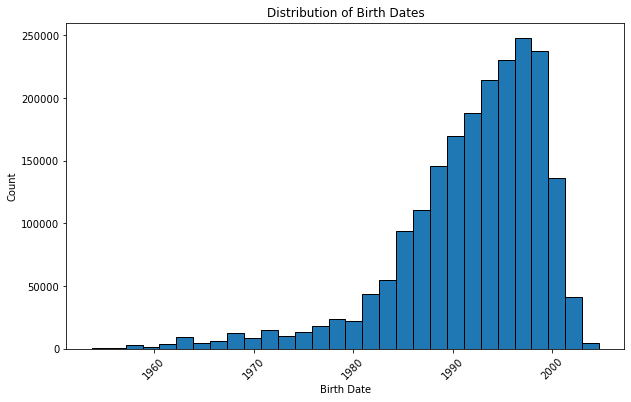

Min Birth Date: 1953-10-01 00:00:00+00:00
Max Birth Date: 2004-09-07 00:00:00+00:00
Mean Birth Date: 1991-11-27 11:38:09.840466048+00:00
Median Birth Date: 1993-04-28 00:00:00+00:00


In [18]:
# Calculate summary statistics
min_birth_date = df['BIRTH_DATE'].min()
max_birth_date = df['BIRTH_DATE'].max()
mean_birth_date = df['BIRTH_DATE'].mean()
median_birth_date = df['BIRTH_DATE'].median()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['BIRTH_DATE'], bins=30, edgecolor='black')
plt.xlabel('Birth Date')
plt.ylabel('Count')
plt.title('Distribution of Birth Dates')
plt.xticks(rotation=45)
plt.show()

# Print summary statistics
print('Min Birth Date:', min_birth_date)
print('Max Birth Date:', max_birth_date)
print('Mean Birth Date:', mean_birth_date)
print('Median Birth Date:', median_birth_date)


## BANK_TIME

In [19]:
# Convert 'BANK_TIME' column to datetime
df['BANK_TIME'] = pd.to_datetime(df['BANK_TIME'])

# Assuming all datetime objects in the 'BANK_TIME' column are in a specific timezone
desired_timezone = pytz.timezone('UTC')

# Localize 'BANK_TIME' column to the desired timezone
df['BANK_TIME'] = df['BANK_TIME'].dt.tz_localize(desired_timezone)

# Define your current datetime
current_datetime = pd.Timestamp('2023-06-01 18:43:00', tz=desired_timezone)

# Perform operations with the timezone-aware 'current_datetime' and 'df['BANK_TIME']'
df['Time_diff'] = (current_datetime - df['BANK_TIME']).dt.days
df['Hours'] = df['BANK_TIME'].dt.hour
df['Weekday'] = df['BANK_TIME'].dt.weekday + 1
df['Year'] = df['BANK_TIME'].dt.year
df['Day_of_Year'] = df['BANK_TIME'].dt.dayofyear
df['Month'] = df['BANK_TIME'].dt.month

               count      mean       std  min  25%  50%  75%    max
Year Month                                                         
2021 9       16674.0  0.397871  1.779366  0.0  0.0  0.1  0.3   75.0
     10      27210.0  0.378618  1.283448  0.0  0.0  0.1  0.3   46.5
     11      29035.0  0.422518  3.458077  0.0  0.0  0.1  0.3  426.0
     12      32175.0  0.426378  5.350467  0.0  0.0  0.1  0.3  500.0
2022 1       31689.0  0.354659  1.441852  0.0  0.0  0.1  0.3   90.6
     2       29743.0  0.332135  1.368121  0.0  0.0  0.1  0.3   96.9
     3       32913.0  0.393671  1.904230  0.0  0.0  0.1  0.3  119.7
     4       34227.0  0.362740  1.641339  0.0  0.0  0.1  0.3  120.0
     5       38165.0  0.360000  1.814105  0.0  0.0  0.1  0.3  150.0
     6       37216.0  0.411474  3.335375  0.0  0.0  0.1  0.3  471.0
     7       57700.0  0.378551  2.530492  0.0  0.0  0.1  0.3  328.3
     8       86925.0  0.325699  2.516305  0.0  0.0  0.1  0.2  494.5
     9      103702.0  0.253925  1.488028  0.0  0

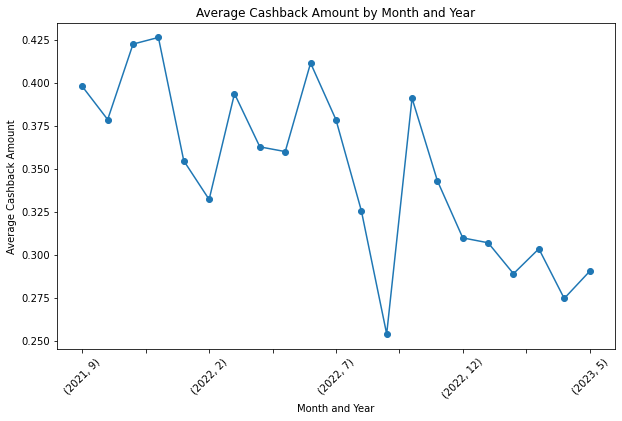

In [20]:
# Convert 'BANK_TIME' column to datetime if not already
df['BANK_TIME'] = pd.to_datetime(df['BANK_TIME'])

# Extract month and year from 'BANK_TIME' column
df['Month'] = df['BANK_TIME'].dt.month
df['Year'] = df['BANK_TIME'].dt.year

# Group data by month and year and calculate statistics
monthly_yearly_cashback_stats = df.groupby(['Year', 'Month'])['CASHBACK_AMOUNT'].describe()

# Print the statistics for each month and year
print(monthly_yearly_cashback_stats)

# Plot the average cashback amount for each month and year
plt.figure(figsize=(10, 6))
df.groupby(['Year', 'Month'])['CASHBACK_AMOUNT'].mean().plot(marker='o')
plt.xlabel('Month and Year')
plt.ylabel('Average Cashback Amount')
plt.title('Average Cashback Amount by Month and Year')
plt.xticks(rotation=45)
plt.show()


In [21]:
df = df.apply(lambda x: x.str.upper() if x.dtype == "object" else x) ## upper case all values

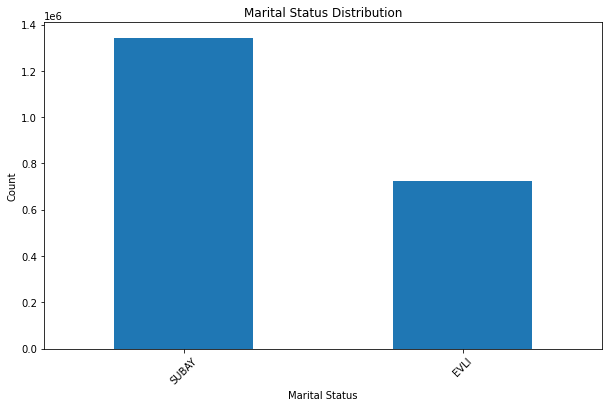

Marital Status Frequencies:
MARSTAT
SUBAY    1341638
EVLI      726203
Name: count, dtype: int64
Cashback Amount Summary Statistics:
count    2.067841e+06
mean     3.178639e-01
std      2.422149e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e-01
75%      2.000000e-01
max      5.000000e+02
Name: CASHBACK_AMOUNT, dtype: float64


In [22]:
# Marital Status Distribution
marstat_counts = df['MARSTAT'].value_counts()

plt.figure(figsize=(10, 6))
marstat_counts.plot(kind='bar')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Marital Status Distribution')
plt.xticks(rotation=45)
plt.show()

print('Marital Status Frequencies:')
print(marstat_counts)

print('Cashback Amount Summary Statistics:')
print(df['CASHBACK_AMOUNT'].describe())

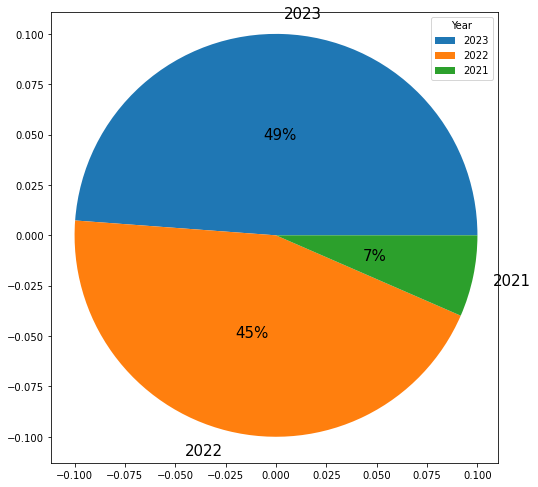

In [23]:
df_year=pd.DataFrame(df.groupby(['Year'])['CASHBACK_AMOUNT'].sum()).sort_values(['CASHBACK_AMOUNT'],ascending=False)
plt.figure(figsize=(8,9))

plt.pie(df_year.CASHBACK_AMOUNT,labels=df_year.index,shadow=False,frame=True,radius=.1, pctdistance = 0.5, autopct = "%0.0f%%",textprops={"fontsize":15} )

plt.legend(title = "Year", loc="upper right")
plt.show()

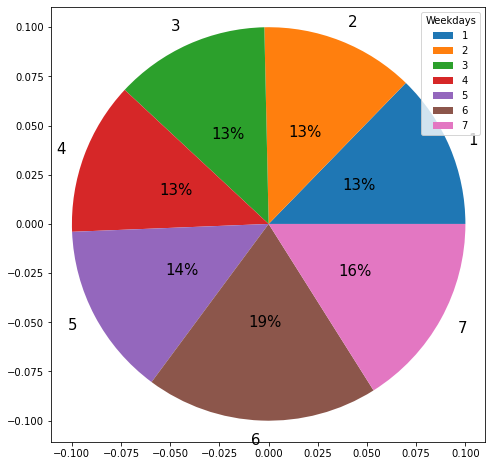

In [24]:
df_weekday=pd.DataFrame(df.groupby(['Weekday'])['CASHBACK_AMOUNT'].sum()).sort_values(['Weekday'],ascending=True)  ## sum
plt.figure(figsize=(8,8))

plt.pie(df_weekday.CASHBACK_AMOUNT,labels=df_weekday.index,shadow=False,frame=True,radius=.1, pctdistance = 0.5, autopct = "%0.0f%%",textprops={"fontsize":15} )

plt.legend(title = "Weekdays", loc="upper right")
plt.show()

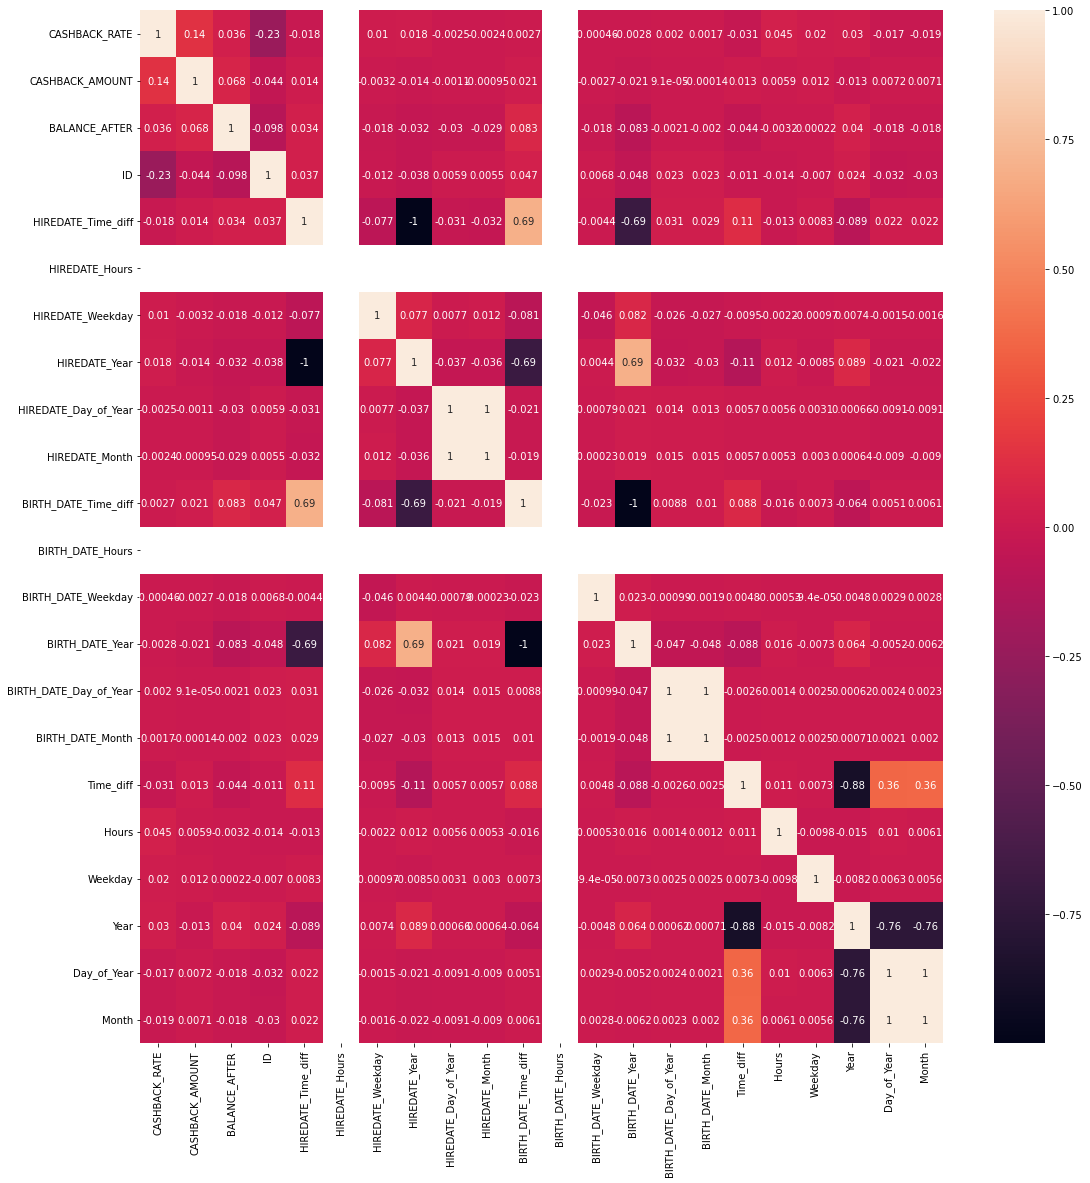

In [25]:
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(18, 19))
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()